# Radiative Transfer Methods using *libRadtran*
The methods for computing satellite channel radiances at TOA as well as the method for retrieving
water-leaving radiance $L_w$ are described below.
## Calculation of Radiances at TOA

The method for calculating TOA radiances in the S3 channels is as follows:
 1. Retrieve the area-averaged surface reflectance from the S3 product by __either__ 
  1. running with several 'albedo' values and interpolating on actual S3-measured radiances, __or__
  2. taking the S3 product back to TOA reflectance and use libRadtran/uvspec in the reflectivity mode
     to retrieve surface reflectance in the same way. This has the advantage that a mismatch in
     TOA solar irradiance between S3 product and that chosen for previous alternative is eliminated.
 2. Compute path transmittance at observation zenith angle by putting the solar zenith angle equal to the
    observation zenith angle and computing the ratio of the direct solar (edir) component at BOA
    as a fraction of the direct solar component at TOA. Only fluxes (irradiances), no radiances, are
    required for this run.
 3. Compute BOA and TOA radiances at true OZA and OAA set up correctly relative to the sun. 
 4. Determine the atmospheric path radiance at TOA by taking the radiance at BOA, multiplying
    by the path transmittance and subtracting this component from the total radiance at TOA
 5. Take the total downwelling irradiance at BOA and multiply by $R_{rs}$ to obtain the 
    water-leaving radiance. 
 6. Compute the sky radiance along the water-observation reflectance vector.
 7. Multiply sky radiance by the Mobley-table reflectance factor to obtain the surface-sky-reflected 
    upwelling radiance at BOA towards satellite.
 8. Multiply surface-sky-reflected radiance by path transmittance computed in (2) to obtain
    residual (surviving) surface-sky-reflected radiance at TOA.
 9. Multiply water-leaving radiance by path transmittance to obtain residual (surviving)
    water-leaving radiance at TOA.
 10. Compute total radiance at TOA by adding residual surface-sky-reflected radiance,
     residual water-leaving radiance and atmospheric path radiance computed in (4).
 11. To retrieve water-leaving radiance, take the sum of the residual sky-reflected
     radiance at TOA and the atmospheric path radiance and subtract this sum from
     actual S3 radiance measurements. This yields an estimate of the residual
     water-leaving radiance at TOA, which, when divided by the path transmittance
     will yield an estimate of the water-leaving radiance at BOA.
 12. Estimated water-leaving radiance at BOA can be divided by the downwelling irradiance
     at BOA to obtain a retrieval of the water remote-sensing reflectance $R_{rs}$.


 Variations on the above procedure could include working with some version of reflectance
 right through the process instead of radiances. Final conversion to radiance would
 then involve the use of the TOA solar irradiances in the S3 product. As with the second variation of
 step 1, this could help to eliminate mismatch due to choice of exoatmospheric solar irradiance spectrum.


 Possible enhancements to the scheme for dealing better with "adjacency" are:
 1. Using vegetation BRDF, probably in the form of RPV parameters from MISR to better estimate the 
    total amount of upwelling radiation from the surface.
 2. Conceive of "adjacency effects" as a combination of three seperable spurious signal components:
  1. Pixel __mixing__, where due to geometrical and optical diffraction effects, the effective
     pixel footprint extends over both water and land/vegetation target areas. This effect would exist
     even if there were no atmosphere.
  2. Atmospheric __adjacency__ which is strictly due to scattering effects in the atmosphere.
  3. __Straylight__ in the optical instrument.

# Radiative Transfer based on Reflectivity
Instead of direct calculation of radiances, there is the alternative (B) above to perform all S3-related computations on the
basis of reflectivity instead. _libRadtran/uvspec_ offers an output option invoked with *output_quantity reflectivity*. 
In this mode, instead of radiance $L$, the computed quantity is
$$ R = \frac{\pi L}{E_0 \cos \theta} .$$
The factor $E_0 \cos \theta$ is the horizontal solar irradiance at TOA, where $\theta$ is the solar zenith angle and
$E_0$ is the (seasonally-corrected) direct solar irradiance at TOA. The horizontal solar irradiance at TOA for a
specific S3 image product are provided within the product. Therefore, if _libRadtran/uvspec_ computes $R$ in the
*output_quantity reflectivity* mode, the S3 channel radiance can be computed as
$$ L = \frac{R}{\pi} E_0 \cos \theta .$$
The the case of fluxes (irradiances), the true irradiance is obtained simply by multiplying the _libRadtran/uvspec_ output
in *output_quantity reflectivity* mode by the TOA solar horizontal irradiance. That is, _libRadtran/uvspec_ outputs the quantity
$$T=\frac{E}{E_0 \cos \theta}$$
and in order to revert to the true irradiance, the solar horizontal irradiance $E_0 \cos \theta$ is taken from the S3 product
and used as
$$E = T \cdot E_0 \cos \theta$$.

In [1]:
import morticia.rad.librad as librad
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import pytz
from scipy.interpolate import interp1d
from ipyparallel import Client  # This is the client class for contacting the hub/controller for compute resources
# use latex for font rendering
mpl.rcParams['text.usetex'] = True  # Use TeX to format labels (takes a bit longer)
%matplotlib inline

In [2]:
# Run this cell to autoreload librad if doing development
%load_ext autoreload
%autoreload 1
%aimport morticia.rad.librad

In [3]:
# Setup compute server identity and credentials
security_profile = 'f2'
server = 'f2.csir.co.za'
username = 'dgriffith'
user_password = 'mandamoggie'

In [4]:

# Create a blank case
S3 = librad.Case(casename='S3toTOAon20160605')


In [5]:
# Set revision
revision = '00A'

# Choose basic atmospheric profile
atmos_profile = '../data/atmmod/afglmw.dat'
S3.set_option('atmosphere_file', atmos_profile)  # mid-latitude winter standard atmosphere

# Modify the ozone and water vapour column amounts
S3.set_option('mol_modify H2O', 10.5, 'MM')  # Total water vapour column in mm
S3.set_option('mol_modify O3', 266.1, 'DU')  # Total ozone column in Dobson units

# Change to the Thuillier spectrum and set wavelength range appropriately
# solar_toa_file = '../data/solar_flux/Solar_irradiance_Thuillier_2002.txt'
# solar_toa_file = '../data/solar_flux/atlas_plus_modtran'
# solar_toa_file = '../data/solar_flux/kurudz_1.0nm.dat'

# Choose start and stop wavelengths and minimum edge margin in nm
wv_minimum_range = [[385.0, -2.0], [955.0, 2.0]]
# Find the nearest wavelengths in the solar file
wv_range = librad.lookup_nearest_in_file('data/Solar_irradiance_Thuillier_2002.txt', wv_minimum_range)  # lookup in local copy
#S3.set_option('source solar', solar_toa_file)
#S3.set_option('wavelength', wv_range[0], wv_range[1])  # Wavelength must exist in the source solar file
#S3.set_option('wavelength', 600.0, 900.0)

# Set up dates and times
overpass_datetime = datetime.datetime(2016, 6, 5, 7, 42, 31, tzinfo=pytz.utc)  # Overpass date and time down to second
overpass_datestr = overpass_datetime.strftime('%Y%m%d')
# Get the day of year
day_of_year = int(overpass_datetime.strftime('%j'))
# S3.set_option('day_of_year', day_of_year)

results_folder = 'ResultsS3on' + overpass_datestr + 'Rev' + revision

# Choose band model
S3.set_option('mol_abs_param reptran_channel', 'sentinel3_olci_b02')

# Choose solver
S3.set_option('rte_solver disort')


# Set ground altitude
S3.set_option('altitude', 1.225)  # ground altitude in km above sea level

# Set ground albedo
S3.set_option('albedo 0.0')

# Set surface pressure
S3.set_option('pressure', 894.0)

# Set up aerosol model
S3.set_option('aerosol_default')
S3.set_option('aerosol_vulcan', 1)               # Aerosol type above 2km
S3.set_option('aerosol_season', 1)               # Summer season
#S3.set_option('aerosol_visibility', 20.0)        # Visibility
S3.set_option('aerosol_haze', 5)                 # Shettle/Fenn urban aerosol
#S3.set_option('aerosol_set_tau_at_wvl Nan Nan')  # To be filled in later per case
aot_wv = np.array([440, 500, 675, 870], dtype=np.float)  # MicroTOPS measurement wavelengths
aot = np.array([0.703, 0.615, 0.362, 0.206])  # MicroTOPS measurements
# Fit Angstrom law to data
alpha, beta = librad.angstrom_law_fit(aot_wv, aot)
# Fit King Byrne formula
alpha_0, alpha_1, alpha_2 = librad.king_byrne_formula_fit(aot_wv, aot)
#S3.set_option('aerosol_angstrom', alpha, beta)
#S3.set_option('aerosol_king_byrne', alpha_0, alpha_1, alpha_2)

# Set up aerosol SSA
SSA_wv = np.array([400.0, 675.0, 875.0, 1020.0])
SSA = np.array([0.9, 0.866, 0.833, 0.8])

# Set up assymmetry parameter
Assym_wv = np.array([400.0, 675.0, 875.0, 1020.0])
Assym = [0.7, 0.61, 0.56, 0.52]

# Use output quantity of reflectivity for all runs
S3.set_option('output_quantity reflectivity')

# Set up viewing and solar geometry. Note that these angles are taken from the S3 product and special
# care has to be taken when putting geometry information into libRadtran
OAA = 104.01066  # deg. Observation azimuth angle (presumably relative to north through east, satellite from dam)
OZA = 14.151356  # deg. Observation zenith angle (satellite zenith angle as seen from the dam)
SAA = 38.719933  # deg. Solar azimuth angle (presumably relative to north through east)
SZA = 59.316036  # deg. Solar zenith angle
cosSZA = np.cos(np.deg2rad(SZA))

# Set the viewing geometry
S3.set_view_geometry(sza=SZA, saa=SAA, oza=OZA, oaa=OAA)

#S3.set_option('verbose')

S3.set_option('zout boa')
S3.purge = False  # Prevent purging of output files


In [6]:
print S3

atmosphere_file ../data/atmmod/afglmw.dat
mol_modify H2O 10.5 MM
mol_modify O3 266.1 DU
mol_abs_param reptran_channel sentinel3_olci_b02
rte_solver disort
altitude 1.225
albedo 0.0
pressure 894.0
aerosol_default 
aerosol_vulcan 1
aerosol_season 1
aerosol_haze 5
output_quantity reflectivity
sza 59.316036
phi0 218.719933
phi 104.01066
umu 0.969653265954
zout boa


In [7]:
# Create list of S3/OLCI channels
S3olciChannelNumbers = range(2,22)  # Bands 2 to 21
S3olciChannels = ['sentinel3_olci_b' + '%02d' % S3olciChannelNumber for S3olciChannelNumber in S3olciChannelNumbers]
# List for all Sentinel 3 OLCI channel centre wavelengths
AllS3olciWavelengths = np.array([
       [  412.5],
       [  442.5],
       [  490.0],
       [  510.0],
       [  560.0],
       [  620.0],
       [  665.0],
       [  673.75],
       [  681.25],
       [  708.75],
       [  753.75],
       [  761.25],
       [  764.375],
       [  767.5],
       [  778.75],
       [  865.0],
       [  885.0],
       [  900.0 ],
       [  940.0],
       [ 1020.0]])
AllS3olciInternalWavelengths = np.array([
       [  412.727478 ],
       [  440.292542],
       [  489.786133],
       [  510.149597],
       [  559.765686],
       [  619.830994],
       [  665.207153],
       [  673.787720],
       [  681.588135],
       [  709.157227],
       [  753.952698],
       [  761.265],
       [  764.4  ],
       [  767.525],
       [  780.472290],
       [  865.818604],
       [  884.106262],
       [  900.11 ],
       [  940.115],
       [ 1008.424805]])

# Compute best fit King Byrne AOT at the representative wavelengths
KingByrneAOTatOLCI = librad.king_byrne_formula(AllS3olciWavelengths, alpha_0, alpha_1, alpha_2)

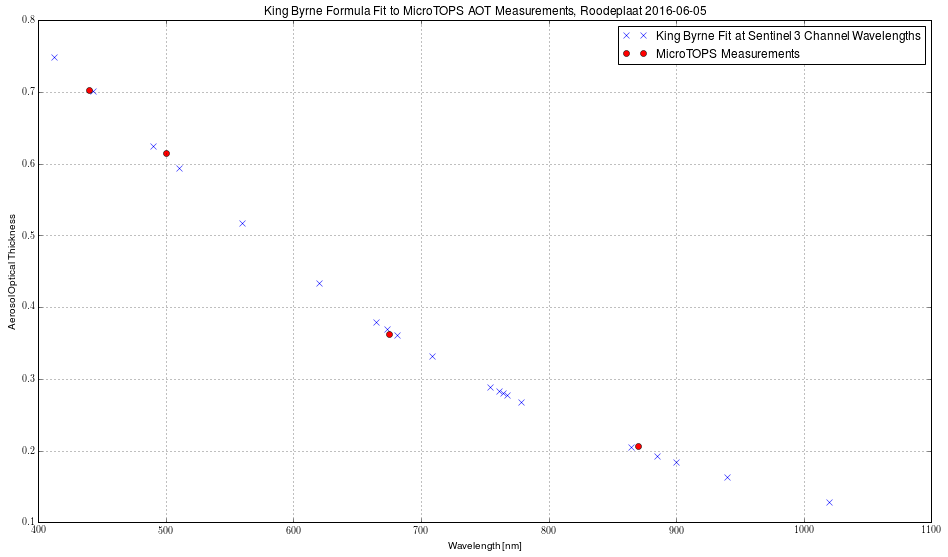

In [8]:
plt.figure(figsize=(16,9))
plt.plot(AllS3olciWavelengths, KingByrneAOTatOLCI, 'x', aot_wv, aot, 'or')
plt.title('King Byrne Formula Fit to MicroTOPS AOT Measurements, Roodeplaat 2016-06-05')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Aerosol Optical Thickness')
plt.legend(['King Byrne Fit at Sentinel 3 Channel Wavelengths', 'MicroTOPS Measurements'])
plt.grid()

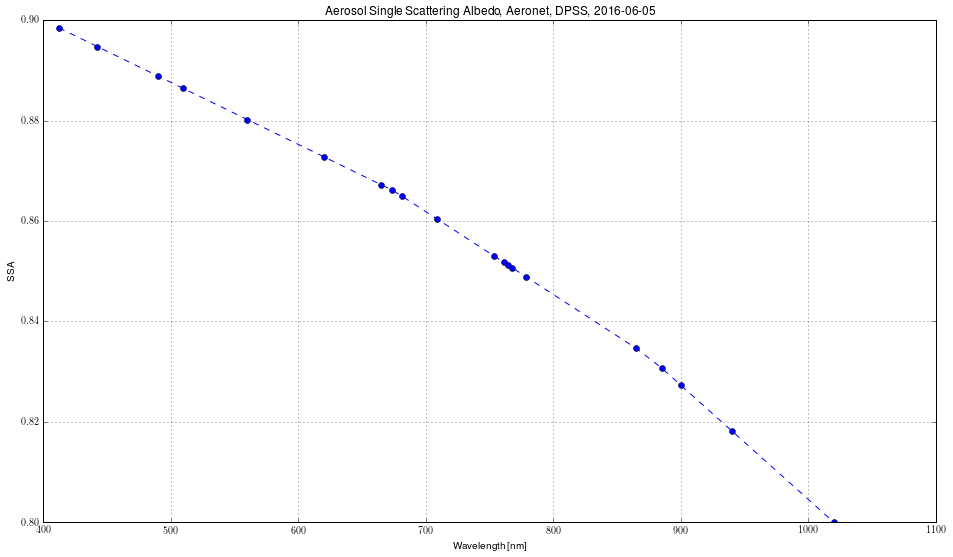

In [9]:
# Now do a simple linear-extrapolated fit to the SSA data
SSAinterpolator = interp1d(SSA_wv, SSA, kind='linear', fill_value='extrapolate')
SSAatS3wvl = SSAinterpolator(AllS3olciWavelengths)
plt.figure(figsize=(16,9))
plt.plot(AllS3olciWavelengths, SSAatS3wvl, linestyle='--', marker='o')
plt.title('Aerosol Single Scattering Albedo, Aeronet, DPSS, 2016-06-05')
plt.xlabel('Wavelength [nm]')
plt.ylabel('SSA')
plt.grid()

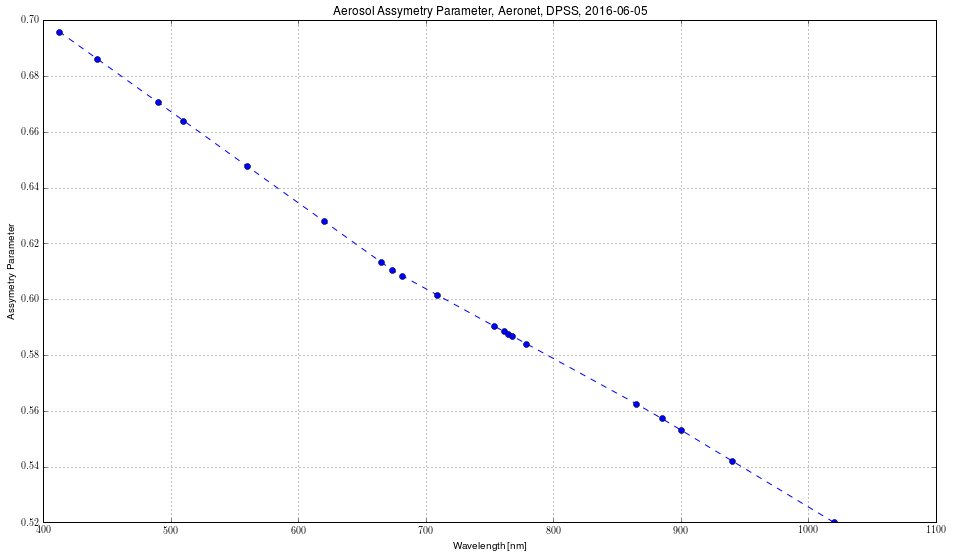

In [10]:
# Simaple linear fit to the assymetry parameter
AssymInterpolator = interp1d(Assym_wv, Assym)
AssymAtS3wvl = AssymInterpolator(AllS3olciWavelengths)
plt.figure(figsize=(16,9))
plt.plot(AllS3olciWavelengths, AssymAtS3wvl, linestyle='--', marker='o')
plt.title('Aerosol Assymetry Parameter, Aeronet, DPSS, 2016-06-05')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Assymetry Parameter')
plt.grid()

In [11]:
# Create a list of cases, one for each S3 channel
import copy
S3allChan = [copy.deepcopy(S3) for S3olciChannel in S3olciChannels]
for iCase, S3Case in enumerate(S3allChan):
    S3Case.set_option('mol_abs_param reptran_channel', S3olciChannels[iCase])
    S3Case.name = 'S3toTOAon20160605' + S3olciChannels[iCase]
    S3Case.set_option('aerosol_modify tau set', KingByrneAOTatOLCI[iCase])
    S3Case.set_option('aerosol_modify ssa set', SSAatS3wvl[iCase])
    #S3Case.set_option('aerosol_modify gg set', AssymAtS3wvl[iCase])
print S3allChan[0]
S3allChan[0].purge = False

atmosphere_file ../data/atmmod/afglmw.dat
mol_modify H2O 10.5 MM
mol_modify O3 266.1 DU
mol_abs_param reptran_channel sentinel3_olci_b02
rte_solver disort
altitude 1.225
albedo 0.0
pressure 894.0
aerosol_default 
aerosol_vulcan 1
aerosol_season 1
aerosol_haze 5
output_quantity reflectivity
sza 59.316036
phi0 218.719933
phi 104.01066
umu 0.969653265954
zout boa
aerosol_modify tau set 0.74866009
aerosol_modify ssa set 0.89845455


In [12]:

# Create the ipyparallel client and contact the hub/controller using the profile called icebow and SSH
# to the machine at the IP address 146.64.246.95
# This will cause ipyparall to look in ~/.ipython/profile_icebow/security for a file named ipcontroller_client.json.
# This file is generated by the hub/controller process when started using the ipcluster or ipcontroller command and
# it may need to be copied from the host running the hub/controller to the machine running the client.
#

paraclient = Client(profile=security_profile, sshserver=username + '@' + server, password=user_password)
# Obtain a "load-balanced" view of the engine cluster
paraview = paraclient.load_balanced_view()
# Set the view to blocking mode, which means that we wait for all engines to complete the task before
# control is returned to the client
paraview.block = True
# We will use dill instead of the standard pickle so that we can send instance methods to engines
paraclient[:].use_dill()

<AsyncResult: use_dill>

In [13]:
# Now try to run the batch on the cluster
S3allChan = paraview.map(librad.Case.run, S3allChan)

In [14]:
# Check return codes for all cases
print [thisS3Case.run_return_code for thisS3Case in S3allChan]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [15]:
# Peep at stderr output for one of the cases
S3allChan[0].stderr

[' ... using CH4 volume mixing ratio profile from US standard atmosphere.\n',
 ' ... using N2O volume mixing ratio profile from US standard atmosphere.\n',
 ' ... using CO volume mixing ratio profile from US standard atmosphere.\n',
 ' ... using N2 volume mixing ratio profile from US standard atmosphere.\n',
 ' ... setting number_of_streams to 16 for radiance calculation!\n',
 ' ... scaling O3   column from      376.19 DU    to       266.1 DU\n',
 ' ... scaling precipitable water from   5.067080 kg/m2 to  10.499996 kg/m2\n',
 'Using new intensity correction, with phase functions\n']

In [16]:
cosSZA = np.cos(np.deg2rad(SZA))
edn = np.vstack([thisS3Case.edn for thisS3Case in S3allChan]) * S3SolarFluxMean * cosSZA
edir = np.vstack([thisS3Case.edir for thisS3Case in S3allChan]) * S3SolarFluxMean * cosSZA
wvl = np.vstack([thisS3Case.wvl for thisS3Case in S3allChan])
plt.figure(figsize=(16,9))
plt.hold(True)
plt.plot(wvl, edn, 'o', linestyle='--', marker='o') 
plt.plot(wvl, edir, 'x', linestyle='--', marker='o')
plt.plot(wvl, edir + edn, 'x', linestyle='--', marker='o')
plt.title('Direct, Diffuse and Total Downward Irradiance at BOA, Roodeplaat, 2016-06-05')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Channel Radiance [$mW/m^2/nm$]')
plt.legend(['Downward Diffuse Irradiance', 'Downward Direct Irradiance', 'Total Downward Irradiance'])
plt.grid()

NameError: name 'S3SolarFluxMean' is not defined

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(wvl, edn/(edn + edir), linestyle='--', marker='o')
plt.title('Diffuse to Global Downward Irradiance Ratio at BOA')
plt.xlabel('Wavelength [$nm$]')
plt.ylabel('Diffuse to Global Irradiance Ratio')
plt.xlim([400.0, 1000.0])
plt.grid()

In [ ]:
# Here we set up the atmosphere and a basic irradiance case to copy for all OLCI channels available in REPTRAN
# Create a blank case
S3 = librad.Case(casename='S3toTOAon20160605')
# Set revision of computation
revision = '00A'
# Build the atmospheric state
# Choose basic atmospheric profile
atmos_profile = '../data/atmmod/afglmw.dat'
S3.set_option('atmosphere_file', atmos_profile)  # mid-latitude winter standard atmosphere

# Modify the ozone and water vapour column amounts
S3.set_option('mol_modify H2O', 10.5, 'MM')  # Total water vapour column in mm
S3.set_option('mol_modify O3', 266.1, 'DU')  # Total ozone column in Dobson units

# Set up dates and times
overpass_datetime = datetime.datetime(2016, 6, 5, 7, 42, 31, tzinfo=pytz.utc)  # Overpass date and time down to second
overpass_datestr = overpass_datetime.strftime('%Y%m%d')
# Get the day of year
day_of_year = int(overpass_datetime.strftime('%j'))
S3.set_option('day_of_year', day_of_year)

results_folder = 'ResultsS3on' + overpass_datestr + 'Rev' + revision

# Choose band model template - will be refined later
S3.set_option('mol_abs_param reptran_channel', 'sentinel3_olci_b??')

# Choose solver
S3.set_option('rte_solver disort')


# Set ground altitude
S3.set_option('altitude', 1.225)  # ground altitude in km above sea level

# Set ground albedo - will be modified for albedo retrieval
S3.set_option('albedo 0.0')

# Set up aerosol model defaults
S3.set_option('aerosol_default')
S3.set_option('aerosol_vulcan', 1)               # Aerosol type above 2km
S3.set_option('aerosol_haze', 5)                 # Shettle/Fenn urban aerosol
S3.set_option('aerosol_season', 1)               # Summer season
S3.set_option('aerosol_modify tau set ??? ???')  # To be filled in later per case
S3.set_option('aerosol_modify ssa set ??? ???')  # To be filled in later per case
#S3.set_option('aerosol_modify gg set ??? ???')  # To be filled in later per case

S3.set_option('output_quantity reflectivity')  # Working with reflectivity and converting to radiances and irradiances

# Want outputs at bottom and top of atmosphere
S3.set_option('zout boa toa')

In [ ]:
# Set up MicroTOPS measurements of aerosol optical thickness
MicroTOPSwvl = np.array([440, 500, 675, 870], dtype=np.float)  # MicroTOPS measurement wavelengths
MicroTOPSaot = np.array([0.703, 0.615, 0.362, 0.206])  # MicroTOPS measurements

# Fit King Byrne formula to MicroTOPS measurements
alpha_0, alpha_1, alpha_2 = librad.king_byrne_formula_fit(MicroTOPSwvl, MicroTOPSaot)


In [ ]:
# Set up viewing and solar geometry. Note that these angles are taken from the S3 product and special
# care has to be taken when putting geometry information into libRadtran
OAA = 104.01066  # deg. Observation azimuth angle (presumably relative to north through east, satellite from dam)
OZA = 14.151356  # deg. Observation zenith angle (satellite zenith angle as seen from the dam)
SAA = 38.719933  # deg. Solar azimuth angle (presumably relative to north through east)
SZA = 59.316036  # deg. Solar zenith angle

In [ ]:
# Create list of S3/OLCI channel wavelength - will not use band 1 - there is no REPTRAN data
S3olciChannelNumbers = range(2,22)  # Bands 2 to 21
S3olciChannels = ['sentinel3_olci_b' + '%02d' % S3olciChannelNumber for S3olciChannelNumber in S3olciChannelNumbers]
# List for all Sentinel 3 OLCI channel centre wavelengths
AllS3olciWavelengths = np.array([
       [  412.5],
       [  442.5],
       [  490.0],
       [  510.0],
       [  560.0],
       [  620.0],
       [  665.0],
       [  673.75],
       [  681.25],
       [  708.75],
       [  753.75],
       [  761.25],
       [  764.375],
       [  767.5],
       [  778.75],
       [  865.0],
       [  885.0],
       [  900.0 ],
       [  940.0],
       [ 1020.0]])
# Compute best fit King Byrne AOT at the representative wavelengths
KingByrneAOTatOLCI = librad.king_byrne_formula(AllS3olciWavelengths, alpha_0, alpha_1, alpha_2)

In [ ]:
# Create a list of runs where the solar zenith angle (SZA) is set to the observation zenith angle (OZA)
# This list of uvspec runs will only be for computation of the observation path transmittance
# Create a list of cases, one for each S3 channel
import copy
S3allChan = [copy.deepcopy(S3) for S3olciChannel in S3olciChannels]
for iCase, S3Case in enumerate(S3allChan):
    S3Case.set_option('mol_abs_param reptran_channel', S3olciChannels[iCase])
    S3Case.name = 'S3toTOAon20160605' + S3olciChannels[iCase]
    S3Case.set_option('aerosol_modify tau set', KingByrneAOTatOLCI[iCase])
    S3Case.set_option('aerosol_modify ssa set', SSAatS3wvl[iCase])
    #S3Case.set_option('aerosol_modify gg set', AssymAtS3wvl[iCase])
    S3Case.set_option('sza', OZA)  # This is not a mistake - want to compute transmittance along sightline

In [ ]:
# Take a look at one of the cases
S3allChan[5]

In [ ]:
# Create the ipyparallel client and contact the hub/controller using the relevant security profile and
# credentials
# This will cause ipyparall to look in ~/.ipython/profile_????/security for a file named ipcontroller_client.json.
# This file is generated by the hub/controller process when started using the ipcluster or ipcontroller command and
# it may need to be copied from the host running the hub/controller to the machine running the client.
#
paraclient = Client(profile=security_profile, sshserver=username + '@' + server, password=user_password)
# Obtain a "load-balanced" view of the engine cluster
paraview = paraclient.load_balanced_view()
# Set the view to blocking mode, which means that we wait for all engines to complete the task before
# control is returned to the client
paraview.block = True
# We will use dill instead of the standard pickle so that we can send instance methods to engines
paraclient[:].use_dill()

In [ ]:
# Now try to run the batch on the cluster
S3allChan = paraview.map(librad.Case.run, S3allChan)

In [ ]:
# Check the return codes - zeros across the board means all is well (generally)
print [thisS3Case.run_return_code for thisS3Case in S3allChan]

In [ ]:
# Can also check the standard error output to diagnose possible problems
S3allChan[0].stderr

In [ ]:
# Next retrieve area-averaged albedo from S3 product
# Set filename for area pixels extracted from SNAP
import pandas as pd
AreaSNAPpixelFile = r'../Data/Sentinel3/S3A_OL_1_EFR____20160605T074147_20160605T074447_20160606T174711_0180_005_049_3419_LN1_O_NT_001_geometry_MaskAARev003.txt'
AreaSNAPpixelData = pd.read_csv(AreaSNAPpixelFile, sep='\t', header=5)

In [ ]:
# Obtain S3 radiances from file for area-averaging
S3RadChannelsAA = AreaSNAPpixelData.filter(regex="Oa[0-9][0-9]_radiance")
# Want to exclude 400 nm band
S3RadChannelsAA = S3RadChannelsAA.drop('Oa01_radiance', 1)

In [ ]:
# Calculate mean radiances and convert to np array
S3MeanRadChannelsAA = np.vstack(S3RadChannelsAA.mean(axis=0))

In [ ]:
# Plot area-averaged S3 radiances centred on Rietvlei
plt.figure(figsize=(9,7))
plt.plot(AllS3olciWavelengths, S3MeanRadChannelsAA, linestyle='--', marker='o', color='b')
plt.title('Area-Averaged Radiance Measured over Roodeplaat on 2016-06-05')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Area-Averaged Radiance from S3 [$mw/m^2/sr/nm$]')
plt.grid()

In [ ]:
# Check out the solar fluxes in the area data
S3SolarFlux = AreaSNAPpixelData.filter(regex="solar_flux_band_[0-9][0-9]?")
# Want to exclude 400 nm band
S3SolarFlux = S3SolarFlux.drop('solar_flux_band_1', 1)
# Calculate mean solar and convert to np array
S3SolarFluxMean = np.vstack(S3SolarFlux.mean(axis=0))

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(AllS3olciWavelengths, S3SolarFluxMean, linestyle='--', marker='o')
plt.title('Mean S3 Overpass Solar Flux at Roodeplaat on 2016-06-05')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Solar Flux [$mW/m^2/nm$]')
plt.grid()

In [ ]:
edir_toa = np.vstack([S3Chan.edir[0][1] for S3Chan in S3allChan]) * S3SolarFluxMean  # Multiply by TOA horizontal solar irradiance
edir_boa = np.vstack([S3Chan.edir[0][0] for S3Chan in S3allChan]) * S3SolarFluxMean
wvl = np.vstack([thisS3Case.wvl for thisS3Case in S3allChan])
plt.plot(wvl, edir_toa)

In [ ]:
S3SolarFluxMean.shape
S3allChan[0].edir

In [ ]:
# Compute the transmission of the satellite sightline
path_transmission = edir_boa / edir_toa

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(wvl, path_transmission, linestyle='--', marker='o', color='b')
plt.title('Satellite Sightline Atmospheric Transmittance, S3, Roodeplaat, 2016-06-05')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmittance')
plt.grid()

In [ ]:
# Compute transmittance using output_quantity
# This is merely to see if there is any difference to previous method
for S3Case in S3allChan:
    S3Case.set_option('output_quantity transmittance')

In [ ]:
S3allChan[0]

In [ ]:
# Now try to run the batch on the cluster
S3allChan = paraview.map(librad.Case.run, S3allChan)

In [ ]:
# Check the return codes - zeros across the board means all is well (generally)
print [thisS3Case.run_return_code for thisS3Case in S3allChan]

In [ ]:
# Compile the direct irradiance expressed as transmittance/reflectance
edir_toa1 = np.vstack([S3Chan.edir[0][1] for S3Chan in S3allChan])
edir_boa1 = np.vstack([S3Chan.edir[0][0] for S3Chan in S3allChan])
wvl1 = np.vstack([thisS3Case.wvl for thisS3Case in S3allChan])

In [ ]:
# Plot the errors - there seems to be a 3% difference - unexplained
plt.plot(wvl, 100.0*(edir_boa1 - path_transmission) / path_transmission, 'o')


In [ ]:
# Set up radiance runs with multiple albedos and correct goemtry
S3Radiance = copy.deepcopy(S3)
S3Radiance.set_option('sza', SZA)  # deg. This one is straightforward
# Now when entering solar and observation zenith angles, it is necessary to provide the azimuth of light propagation
# rather than the azimuth of the view direction, which is 180 deg different
S3Radiance.set_option('phi0', 180.0 - SAA)  # solar radiation propagation azimuth from north through east
S3Radiance.set_option('phi', OAA)  # This is the azimuth of the satellite as seen from the target - also azimuth of light propgation
S3Radiance.set_option('umu', np.cos(np.deg2rad(OZA))) # For downward-looking (upward propagating), check that umu is positive

In [ ]:
S3Radiance

In [ ]:
# Choose a number of albedos at which to run the retrieval
Albedos = np.linspace(0.0, 0.3, 4)
S3allChanRad = [[copy.deepcopy(S3Radiance) for S3olciChannel in S3olciChannels] for Albedo in Albedos]

In [ ]:
# Set the albedos and aerosol optical depths
for iAlb, Albedo in enumerate(Albedos):
    for iCase, S3Case in enumerate(S3allChanRad[iAlb]):
        S3Case.set_option('mol_abs_param reptran_channel', S3olciChannels[iCase])
        S3Case.name = 'S3toTOAon20160605' + S3olciChannels[iCase]
        S3Case.set_option('aerosol_modify tau set', KingByrneAOTatOLCI[iCase])
        S3Case.set_option('aerosol_modify ssa set', SSAatS3wvl[iCase])
        #S3Case.set_option('aerosol_modify gg set', AssymAtS3wvl[iCase])
        S3Case.set_option('albedo', Albedo)

In [ ]:
# Display an example
S3allChanRad[1][0]

In [ ]:
# Test run for a set of albedos
S3allChanRad[0] = paraview.map(librad.Case.run, S3allChanRad[0])

In [ ]:
# Now try to run the entire batch on the cluster
for iAlb, Albedo in enumerate(Albedos):
    S3allChanRad[iAlb] = paraview.map(librad.Case.run, S3allChanRad[iAlb])

In [ ]:
# Extract radiance results from all runs (all surface albedo values and all S3 channels)
RadTOA = np.hstack([np.vstack([S3allChanRad[iAlb][iChan].uu.squeeze()[1] for iAlb in range(len(Albedos))] 
                for iChan in range(len(AllS3olciWavelengths)))]) * S3SolarFluxMean * cosSZA / np.pi

In [ ]:
# Plot the predicted radiances at TOA for various albedo levels together with actual measurements from S3
plt.figure(figsize=(9,7))
plt.hold(True)
for iAlb, Albedo in enumerate(Albedos):
    plt.plot(AllS3olciWavelengths, RadTOA[:, iAlb],  linestyle='--', marker='o')
plt.plot(AllS3olciWavelengths, S3MeanRadChannelsAA, linestyle='--', marker='o', color='k')
plt.title('Modelled and Measured TOA Radiances over Roodeplaat on 2016-06-05')
plt.xlabel('Wavelength [nm]')
plt.ylabel('TOA Radiance [$mw/m^2/sr/nm$]')
# Build the legends
theLegends = ['Albedo = ' + str(Albedo) for Albedo in Albedos]
plt.legend(theLegends + ['S3 Measured'])
plt.grid()

In [ ]:
# Check linearity - linearity looks good between albedo of 0.0 and 0.3
# As with MODTRAN, there is some deviation from linearity at higher albedos
plt.figure(figsize=(9,7))
plt.plot(Albedos, RadTOA.T, linestyle='--', marker='o')
plt.title('Linearity of Predicted S3 Radiance with respect to Surface Albedo')
plt.xlabel('Albedo')
plt.ylabel('Radiance [$mw/m^2/sr/nm$]')
plt.grid()

In [ ]:
# Calculate area-averaged surface albedo by interpolating in albedo to the actual measured S3 radiances
RetrievedSurfAlbedo = np.zeros(AllS3olciWavelengths.size)
for iChn in range(len(AllS3olciWavelengths)):
    RetrievedSurfAlbedo[iChn] = np.interp(S3MeanRadChannelsAA[iChn], RadTOA[iChn, :], Albedos)
    
### Manipulate the surface reflectance in the blue by hand to observe the effect on the output

In [ ]:
# Plot the retrieved albedos - overall shape very similar to MODTRAN retrieval
# Band 3 (second point, at 442.5 nm) is artificially high, suspected to be a solar TOA spectrum issue
plt.figure(figsize=(9,7))
plt.plot(AllS3olciWavelengths, RetrievedSurfAlbedo, linestyle='--', marker='o')
plt.title('Retrieved Surface Equivalent Lambertian Albedo, Roodeplaat, 2016-06-05')
plt.xlim([400.0, 900.0])
plt.xlabel('Wavelength [nm]')
plt.ylabel('Albedo')
plt.grid()

In [ ]:
# Now set up the runs with retrieved albedos to get downwelling spectral irradiance at the surface
for iCase, Case in enumerate(S3allChan):
    Case.set_option('albedo', RetrievedSurfAlbedo[iCase])
    Case.set_option('sza', SZA)
    Case.set_option('output_quantity reflectivity')

In [ ]:
S3allChan[1]

In [ ]:
# Run the irradiance cases and check the return codes
S3allChan = paraview.map(librad.Case.run, S3allChan)
print [S3Chan.run_return_code for S3Chan in S3allChan]

In [ ]:
# Extract the irradiances
edir_toa = np.vstack([S3Chan.edir[0][1] for S3Chan in S3allChan]) * S3SolarFluxMean * cosSZA
edir_boa = np.vstack([S3Chan.edir[0][0] for S3Chan in S3allChan]) *  S3SolarFluxMean * cosSZA
edn_toa = np.vstack([S3Chan.edn[0][1] for S3Chan in S3allChan]) * S3SolarFluxMean * cosSZA
edn_boa = np.vstack([S3Chan.edn[0][0] for S3Chan in S3allChan]) * S3SolarFluxMean * cosSZA

In [ ]:
total_edn_toa = edir_toa + edn_toa
total_edn_boa = edir_boa + edn_boa

In [ ]:
plt.plot(AllS3olciWavelengths, total_edn_boa,  linestyle='--', marker='o')

In [ ]:
# Read R_rs for above-water measurements on 2016-06-05
R_rs = np.genfromtxt('../Data/Rrs/Roodeplaat_ASD_rrs.txt')

In [ ]:
wvlR_rs = R_rs[:, 0]
R_rs = R_rs[:, [1,3,5,7]]

In [ ]:
plt.plot(wvlR_rs, R_rs)

In [ ]:
# Compute R_rs at the S3 wavelengths - this is a bit crude
R_rsS3wvl = np.interp(AllS3olciWavelengths, wvlR_rs, R_rs.mean(axis=1))

In [ ]:
# Plot R_rs at S3 wavelengths
plt.plot(AllS3olciWavelengths, R_rsS3wvl)

In [ ]:
# Compute and plot the water-leaving radiance
L_w = R_rsS3wvl * total_edn_toa
plt.plot(AllS3olciWavelengths, L_w)

In [ ]:
# Set up the sky radiance run to compute the water-reflected radiance
# The BOA radiance looking upward at the sky must be computed.
# Add 180 degrees to the azimuth
for iCase, Case in enumerate(S3allChan):
    Case.set_option('phi0', 180.0 - SAA)  # solar radiation propagation azimuth from north through east
    Case.set_option('phi', 180.0 - OAA)  # Swing observation azimuth through 180 degrees compared to downward-looking case
    Case.set_option('umu', np.cos(np.deg2rad(180.0-OZA))) # For upward-looking (downward propagating), check that umu is negative
    

In [ ]:
S3allChan[0]

In [ ]:
# Run the cases and get the upward-looking radiance at BOA
S3allChan = paraview.map(librad.Case.run, S3allChan)
print [S3Chan.run_return_code for S3Chan in S3allChan]

In [ ]:
sky_radiance = np.vstack([S3Chan.uu.squeeze()[0] for S3Chan in S3allChan]) * S3SolarFluxMean * cosSZA / np.pi


In [ ]:
plt.plot(AllS3olciWavelengths, sky_radiance)

In [ ]:
water_reflectance = 0.02  # Obtained from Mobley tables - need to get this value per situation
water_reflected_radiance = sky_radiance * water_reflectance
plt.hold(True)
plt.plot(AllS3olciWavelengths, water_reflected_radiance, linestyle='--', marker='o')
plt.plot(AllS3olciInternalWavelengths, L_w, linestyle='--', marker='x')

In [ ]:
L_w_atTOA = L_w * path_transmission
water_reflected_radiance_atTOA = path_transmission

In [ ]:
plt.hold(True)
plt.plot(AllS3olciWavelengths, water_reflected_radiance_atTOA, linestyle='--', marker='o')
plt.plot(AllS3olciInternalWavelengths, L_w_atTOA, linestyle='--', marker='x')

In [ ]:
# Set up the downward-looking radiance run with area-averaged reflectance
for iCase, Case in enumerate(S3allChan):
    Case.set_option('phi0', 180.0 - SAA)  # solar radiation propagation azimuth from north through east
    Case.set_option('phi', OAA)  # Swing observation azimuth through 180 degrees compared to downward-looking case
    Case.set_option('umu', np.cos(np.deg2rad(OZA))) # For upward-looking (downward propagating), check that umu is negative
    

In [ ]:
# Print a sample
S3allChan[0]

In [ ]:
# Run the cases and get the downward-looking radiance at BOA and at TOA
S3allChan = paraview.map(librad.Case.run, S3allChan)
print [S3Chan.run_return_code for S3Chan in S3allChan]

In [ ]:
# Compile the BOA and TOA Radiances
BOA_radiance = np.vstack([S3Chan.uu.squeeze()[0] for S3Chan in S3allChan]) * S3SolarFluxMean * cosSZA / np.pi
TOA_radiance = np.vstack([S3Chan.uu.squeeze()[1] for S3Chan in S3allChan]) * S3SolarFluxMean * cosSZA / np.pi

In [ ]:
plt.hold(True)
plt.plot(AllS3olciWavelengths, BOA_radiance, linestyle='--', marker='o')
plt.plot(AllS3olciWavelengths, TOA_radiance, linestyle='--', marker='o')

In [ ]:
# Compute TOA radiance minus the BOA radiance multiplied by the transmittance to
# get atmospheric path radiance
atm_path_radiance = TOA_radiance - BOA_radiance * path_transmission

In [ ]:
plt.plot(AllS3olciWavelengths, atm_path_radiance, linestyle='--', marker='o')

In [ ]:
# Compute total radiance at TOA and compare to S3 radiances for selected pixel
total_radiance_atTOA = atm_path_radiance + L_w_atTOA + water_reflected_radiance_atTOA
plt.plot(AllS3olciWavelengths, total_radiance_atTOA, linestyle='--', marker='o')

In [ ]:
# Read the "best" S3 pixel for the day
WaterSNAPpixelFile = r'../Data/Sentinel3/S3_0605_Roodeplaat_data.txt'
WaterSNAPpixelData = pd.read_csv(WaterSNAPpixelFile, sep='\t', header=5)

In [ ]:
WaterSNAPpixelData

In [ ]:
# Obtain S3 radiances
S3RadChannelsWater = WaterSNAPpixelData.filter(regex="Oa[0-9][0-9]_radiance")
# Want to exclude 400 nm band
S3RadChannelsWater = S3RadChannelsWater.drop('Oa01_radiance', 1)
S3RadallChanWater = np.vstack(S3RadChannelsWater.mean(axis=0))

In [ ]:
S3RadChannelsWater

In [ ]:
plt.hold(True)
plt.plot(AllS3olciWavelengths[0:-1], np.array(S3RadallChanWater), linestyle='--', marker='o')
plt.plot(AllS3olciWavelengths, total_radiance_atTOA, linestyle='--', marker='o')

In [ ]:
# Retrieve water-leaving radiance
retrieved_Lw_atTOA = S3RadallChanWater - atm_path_radiance[0:-1] - water_reflected_radiance_atTOA[0:-1]
retrieved_Lw_atBOA = retrieved_Lw_atTOA / path_transmission[0:-1]

In [ ]:
plt.figure(figsize=(16,9))
plt.hold(True)
plt.plot(AllS3olciWavelengths[0:-1], retrieved_Lw_atBOA, linestyle='--', marker='o')
plt.plot(AllS3olciWavelengths, L_w, linestyle='--', marker='o')
plt.grid()